# Hydrology - Coupled vs Free (BEACH only)

Before runing this file, run: "copy_results.py" inside master folder.

In [1]:
from metrics import *
import os
import seaborn as sns
import numpy as np
# plt.style.use('seaborn-white')
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# sys.path.append(path + '\\visuals\\')

path = os.getcwd()

In [2]:
path

'C:\\Users\\pablo\\Documents\\Coupling\\beach2lisem_v2\\master\\visuals'

In [3]:
runoff_array = np.loadtxt(path + "\\res\\4\\hydro.txt", skiprows=3, delimiter=",",
                                                      usecols=(0, 1, 2, 3))
# Convert to m3/time-step, then sum all rows for the total discharged vol.
# m3 = min x L/s x 1 m3/10^3 L x 60s/min
m3 = 9./60. * runoff_array[:, 3] * (1. / 10 ** 3) * 60.
GA_runoff_m3 = m3.cumsum()[-1]

In [4]:
GA_runoff_m3

1424.0610000000158

In [5]:
# Save coupled model results
lisem_sims = 5
concat_periods("Q", lisem_sims + 1, path)
concat_periods("LF", lisem_sims + 1, path)
concat_periods("ROFF", lisem_sims + 1, path)
concat_periods("ADR", lisem_sims + 1, path)
concat_periods("BF", lisem_sims + 1, path)

concat_periods("Bal_W", lisem_sims + 1, path)

In [6]:
free = path + "\\output_free\\0\\"
q_free = get_dataframe(free, "Q_out")
q_free = q_free.rename(index=str, columns={"Q Sim.": "Q Free."})
get_kge(q_free, "Qm3", "Q Free.")

0.7293207472540719

In [7]:
q_free.head()

,Jdays,Qm3,Q Free.
0,177,28.678,41.8379
1,178,28.655,41.6690
2,179,28.440,41.6590
3,180,30.559,41.6479
4,181,29.590,41.6373


In [8]:
coup = path + "\\output_coup\\all\\"
q_coup = get_dataframe(coup, "Q_out")
q_coup = q_coup.rename(index=str, columns={"Q Sim.": "Q Coup."})
get_kge(q_coup, "Qm3", "Q Coup.")

0.5631538902485929

In [9]:
# q_coup.tail()

In [10]:
q_free2 = q_free[["Jdays","Q Free."]]
match = pd.merge(q_coup, q_free2, how='inner', on='Jdays')
match.head()

,Jdays,Qm3,Q Coup.,Q Free.
0,177,28.678,41.8430,41.8379
1,178,28.655,41.6728,41.6690
2,179,28.440,41.6618,41.6590
3,180,30.559,41.6500,41.6479
4,181,29.590,41.6389,41.6373


In [11]:
dm_simp = pd.melt(match, 
                 id_vars=['Jdays'
                         ],
#              value_vars=['z3_factor',
                 )

## Plotting

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


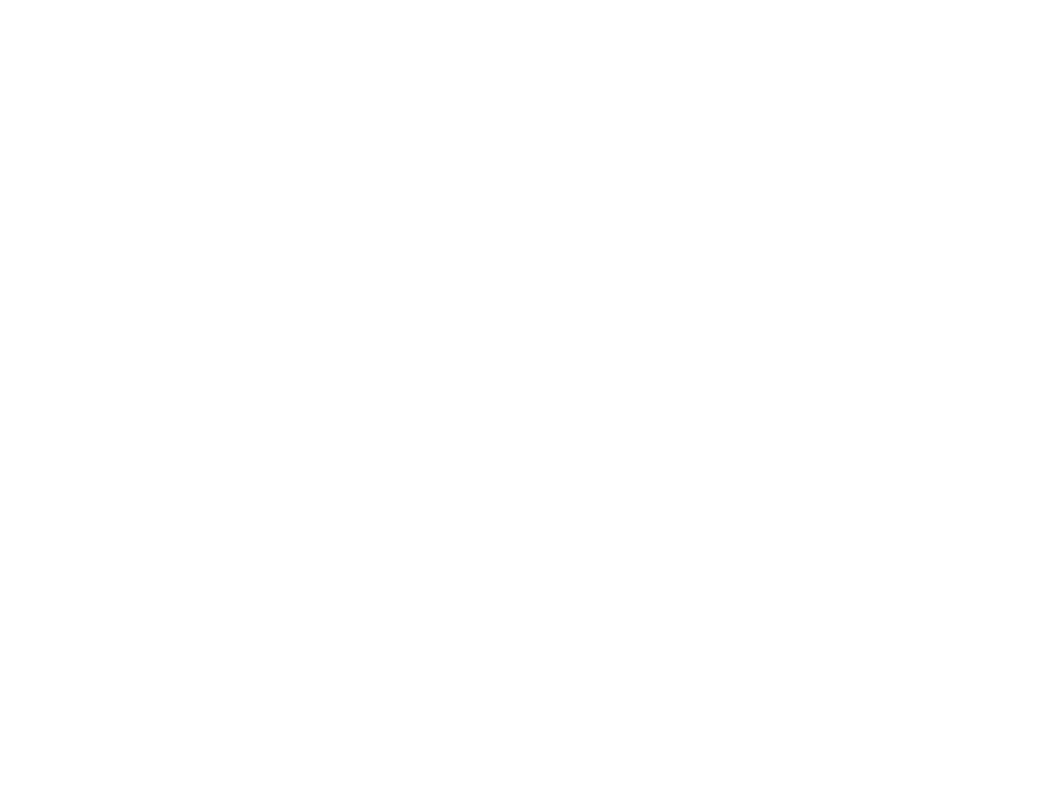

In [13]:
q_only = sns.lineplot(x="Jdays", y="value",
             hue="variable", 
#              style="event",
             data=dm_simp)

## Plotting multiple components

In [14]:
tss = [#"resW_accQ_m3.tss", # Q sim
       "resW_outLatflow_m3.tss",  # Outlet latflow (m3)
       "resW_accRunoff_m3.tss",  # Runoff (m3)
       "resW_accDrain_m3.tss",  # Drainage (m3)
       "resW_accBaseflow_m3.tss"  # Baseflow, linear reservoir (m3)
      ] 

names = [#'Q ', 
         'LF ', 
         'ROFF ', 
         'Drain ', 
         'BF '
        ]

palette = ['blue', 'purple', 'rgb(178,223,138)', '#F44336', '#3F51B5', 'orange']


In [15]:
def append_components(parent, path, sim_type):    
    
    # data.append(obs_q)
    for i in range(len(tss)):  # Append simulated components
        filename = tss[i]
        sim_pd = pd.read_table(path + filename, 
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', names[i]+sim_type],
                                header=None)

        parent.append(sim_pd)
    return parent

In [16]:
data_free= [q_free]
data_free = append_components(data_free, free, 'Free')
df_free = reduce(lambda left, right: pd.merge(left, right, on='Jdays'), data_free)
df_free.head()

,Jdays,Qm3,Q Free.,LF Free,ROFF Free,Drain Free,BF Free
0,177,28.678,41.8379,0.013069,0.158751,0.0,41.6661
1,178,28.655,41.6690,0.014112,0.000000,0.0,41.6549
2,179,28.440,41.6590,0.015432,0.000000,0.0,41.6435
3,180,30.559,41.6479,0.015854,0.000000,0.0,41.6321
4,181,29.590,41.6373,0.016764,0.000000,0.0,41.6205


In [17]:
data_coup = [q_coup]
data_coup = append_components(data_coup, coup, 'Coup')
df_coup = reduce(lambda left, right: pd.merge(left, right, on='Jdays'), data_coup)
df_coup.tail()

,Jdays,Qm3,Q Coup.,LF Coup,ROFF Coup,Drain Coup,BF Coup
105,282,58.464,51.1452,0.038228,0.0000,6.11699,44.9900
106,283,56.186,50.5840,0.042859,0.0000,5.56174,44.9794
107,284,54.981,50.0787,0.040740,0.0000,5.06920,44.9688
108,285,53.592,124.1670,0.039338,74.5426,4.62726,44.9581
109,286,22.995,49.2143,0.039848,0.0000,4.22704,44.9474


In [18]:
mfree = pd.melt(df_free, 
                 id_vars=['Jdays'
                         ],
#              value_vars=['z3_factor',
                 )

In [19]:
mcoup = pd.melt(df_coup, 
                 id_vars=['Jdays'
                         ],
#              value_vars=['z3_factor',
                 )

<IPython.core.display.Javascript object>


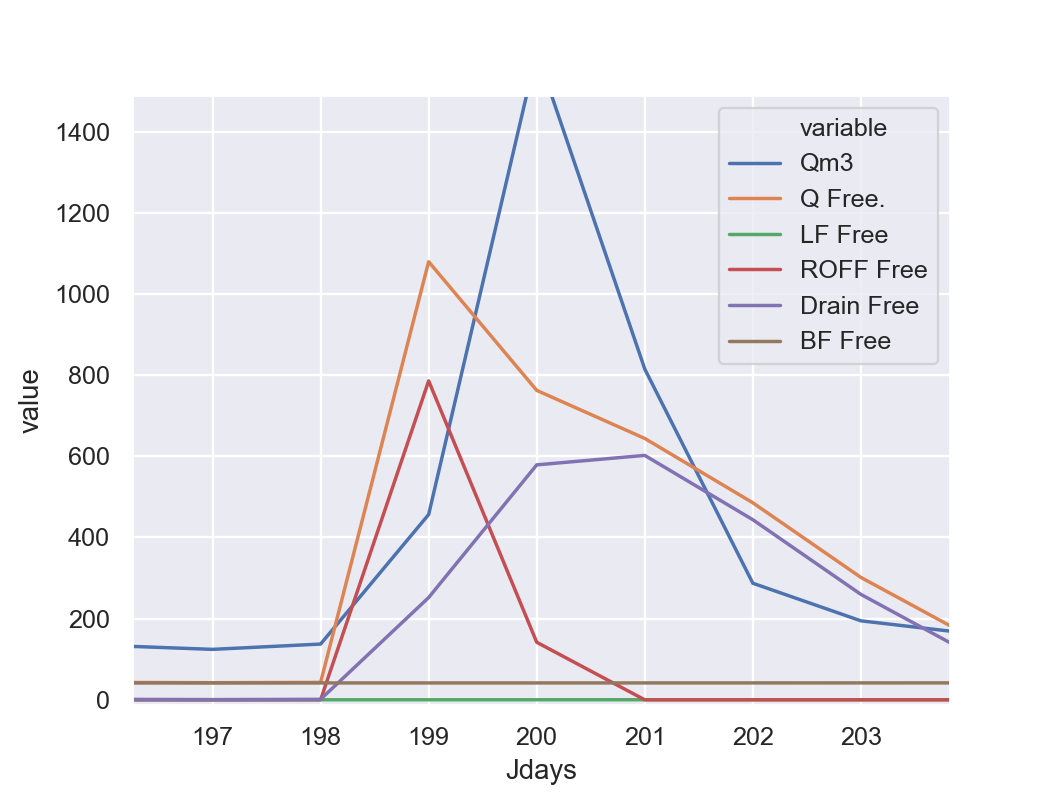

In [23]:
%matplotlib notebook
f = sns.lineplot(x="Jdays", y="value",
             hue="variable", 
#              style="event",
             data=mfree)
f

<IPython.core.display.Javascript object>


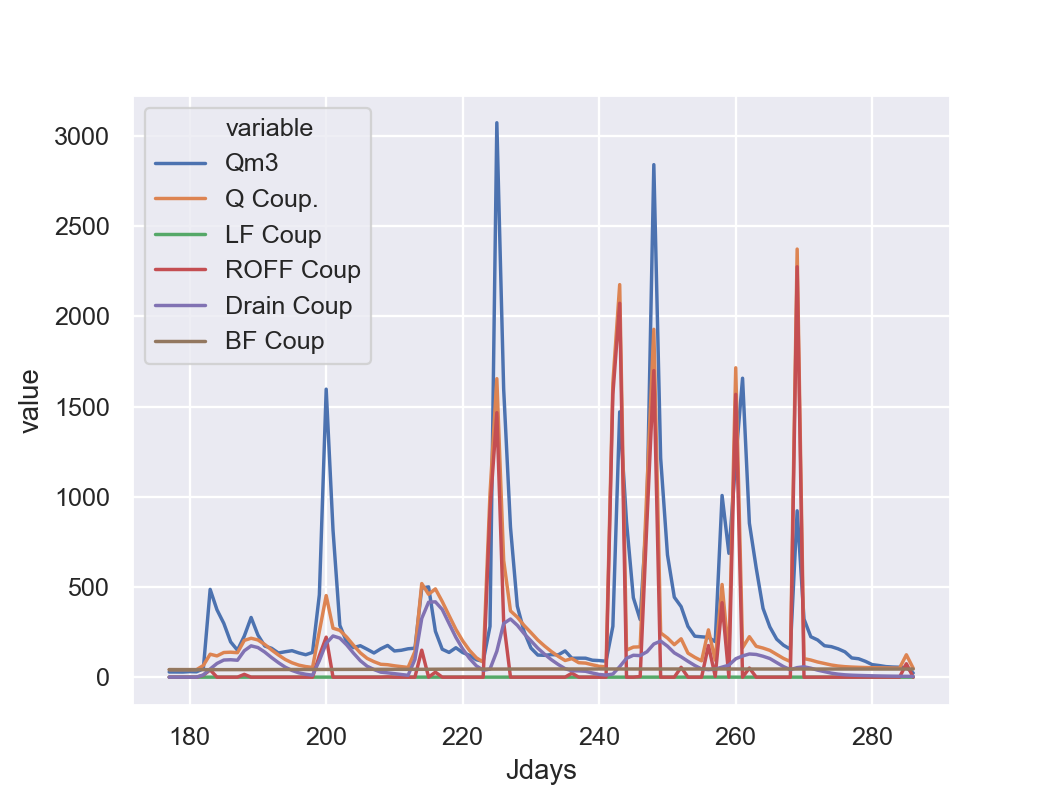

In [22]:
%matplotlib notebook
c = sns.lineplot(x="Jdays", y="value",
             hue="variable", 
#              style="event",
             data=mcoup)
c


In [24]:
0.0239 * 427.1558

10.20902362